# Minicourse of Bayesian Machine Learning for Scientific Research
## Lecture 1

This notebook contains problems and discussions for the course.  We want you to pay attention and participate in the lectures, this is why, on-purpose, notebooks are not self-contained.  It has many comments that should be uncommented and tested, etc.  And many important comments are discussed in the lectures.

This notebook if intended solely for the Minicourse of Bayesian Machine Learning for Scientific Research.  Ezequiel Alvarez (sequialvz@gmail.com)

In [72]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

# Linear regression

A first 'Hello world' script for STAN.  We fit a linear problem (straight line) in an alternative way to least squares, and find how this Bayesian techniques become useful as the problem gets more involved!

Problem: We want to measure how much a town pollutes a river, hence we take water samples along the river at different distances (x) and we measure how much pollution (y) there is in the water.  However, at the begining of our itinerary ( x ~ 0 ) we have a bias, because we can only access the river through streets that are close to water waastes, and we expect to measure larger than what it is.  

We start with a simple problem and we get more involved as we go.

#### Generate data

In [334]:
# We assume a linear model, that is that pollution y increases linearly with the distance x, and that there is an initial pollution already in the river.
np.random.seed(1)
m = 5
b = 25
noise = 10
x = np.random.uniform(0,20,10)
#x_biased = np.random.uniform(0,20,10)
y = []
#y_biased = []
for i in range(len(x)):
    y.append( m * x[i] + b + np.random.normal(0,noise) )    
 #   y_biased.append( m * x_biased[i] + b + np.random.normal(bias,noise) )    


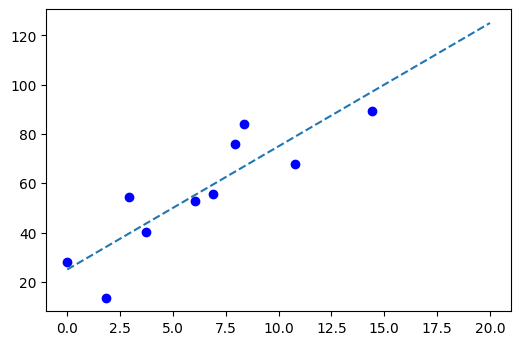

In [335]:
x0 = np.linspace(0,20,10)
plt.scatter(x,y, color = 'blue')
#plt.scatter(x_biased,y_biased, color='red')
plt.plot(x0, m*x0+b, linestyle='dashed')
#plt.ylim(0,max(y)*1.10)
plt.show()

#### Inference with Stan

In [336]:
contamination_model="""
data {
 int <lower=0> N;
 vector[N] x;
 vector[N] y;
}

parameters {
  real m;
  real b;
  real<lower=0> sigma;
}
model {
  //b ~ normal(10,10);
  y ~ normal(m * x + b, sigma);
}
"""

In [337]:
contamination_data={ 'N': len(x), 'x': x, 'y': y}

In [338]:
model = stan.build(contamination_model, data=contamination_data, random_seed=1);

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [339]:
fit = model.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.01 seconds.
  Adjust your expectations accordingly!


In [340]:
df = fit.to_frame() 

In [341]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,m,b,sigma
draws,,,,,,,,,,
0,-27.025086,0.993986,0.290770,4.0,23.0,0.0,28.788396,5.270661,22.114062,11.286140
1,-27.582881,0.958587,0.340931,3.0,7.0,0.0,27.985964,5.711835,23.346457,12.216973
2,-31.740084,0.670244,0.303789,4.0,15.0,0.0,33.046740,1.349530,42.969305,16.847142
3,-29.050886,0.904014,0.319210,3.0,7.0,0.0,30.137474,4.494574,21.340390,19.598356
4,-28.392551,0.799095,0.290770,4.0,15.0,0.0,29.651920,3.350246,31.371366,15.057828
...,...,...,...,...,...,...,...,...,...,...
3995,-28.820107,0.732390,0.319210,3.0,11.0,0.0,35.767806,6.773614,13.688867,12.811978
3996,-27.007003,0.997446,0.290770,2.0,7.0,0.0,27.332398,4.887964,27.666961,11.766177
3997,-28.457773,0.537723,0.340931,1.0,1.0,0.0,30.407668,4.739870,19.158628,12.984764


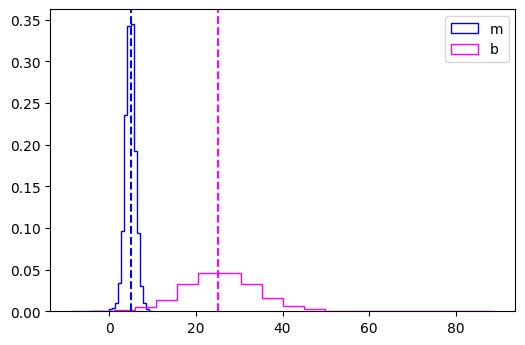

In [343]:
x0 = np.linspace(0,40,100)
plt.hist(df['m'], histtype='step', bins=20, density=1, color='blue', label='m')
plt.axvline(x=m, linestyle='dashed', color='blue')
plt.hist(df['b'], histtype='step', bins=20, density=1, color='magenta', label='b')
#plt.plot(x0, stats.norm.pdf(x0,10,10), 'm:', label='b-prior')
plt.axvline(x=b, linestyle='dashed', color='magenta')
plt.legend()
plt.show()

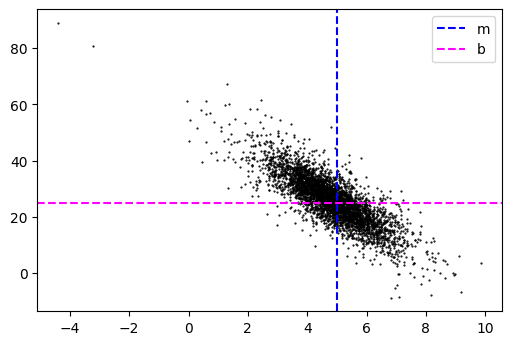

In [344]:
plt.scatter(df['m'],df['b'], s=0.3, color='black')
plt.axvline(m, linestyle='dashed', label='m', color='blue')
plt.axhline(b, linestyle='dashed', label='b', color='magenta')
plt.legend()
plt.show()

#### Observations and exercises

- It makes sense, because of where the datapoints are, that if m decreases then b increases to better fit all the points
- Try: using a bad prior on e.g. the b parameter b ~ N(10,10)
- Try: plot the prior and verify how the posterior improves
- Try: verify that with a large dataset (~100 datapoints) the prior is 'forgotten'
- Try: increase the dataset to ~500 and check that convergence to true is retrieved with the correct model

### Now Let's try with the biased sample

The previous example can be easily solved using least squares obtaining similar results.  However, if the problem gets more involved, we can get more from the Bayesian tools.

Let's consider that the measurement on the river's waters is expected to have some bias that depends on the river course.  Closest to the city, the water is less mixed and it is likely that where we take the water sample, is closer to some water flush.  Hence a positive bias is expected at the low x.

In [345]:
np.random.seed(1)
m = 5
b = 25
noise = 10
bias = 20
#x = np.random.uniform(0,20,10)
x_biased = np.random.uniform(0,20,10)
#y = []
y_biased = []
for i in range(len(x)):
    # The bias consists of the noise not being central, but being slightly positive.  How positive? Determined through an exponential in the Normal central value
    y_biased.append( m * x_biased[i] + b + np.random.normal(bias*(np.exp(-(x_biased[i])/10)),noise) )    


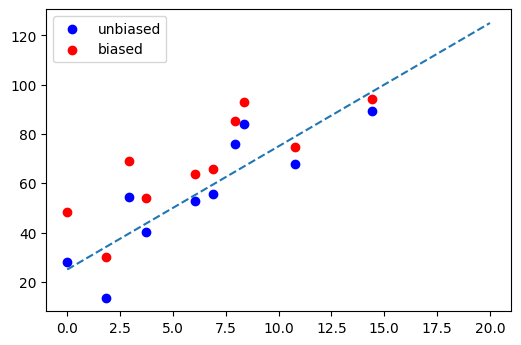

In [387]:
x0 = np.linspace(0,20,100)
plt.scatter(x,y, color = 'blue', label='unbiased')
plt.scatter(x_biased,y_biased, color='red', label='biased')
plt.plot(x0, m*x0+b, linestyle='dashed')
plt.legend()
#plt.ylim(0,max(y)*1.10)
plt.show()

In [388]:
contamination_model_with_bias="""
data {
 int <lower=0> N;
 vector[N] x;
 vector[N] y;
 
}

parameters {
  real m;
  real b;
  real<lower=0> sigma;
  real<lower=0> bias;
}
model {
  bias ~ cauchy(0,10);  // we are using a half cauchy because bias >= 0 
  // Let's use a 'for' to create the model, which is always more clear!
  //for (n in 1:N) {
  //  y[n] ~ normal(m * x[n] + b + bias*exp(-x[n]/10), sigma);
  //  };
   y ~ normal(m * x + b + bias*exp(-x/10), sigma);
}
"""

In [389]:
contamination_data_biased={ 'N': len(x_biased), 'x': x_biased, 'y': y_biased}

### Biased data on unbiased model

In [396]:
model = stan.build(contamination_model, data=contamination_data_biased, random_seed=1);

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [397]:
fit = model.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!


In [398]:
df = fit.to_frame() 

In [399]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,m,b,sigma
draws,,,,,,,,,,
0,-28.122783,0.991740,0.305083,3.0,15.0,0.0,31.112030,2.772793,51.473215,17.690504
1,-29.284441,0.997170,0.410830,3.0,7.0,0.0,30.077332,3.065930,52.943997,21.619897
2,-29.393155,0.970769,0.279963,2.0,7.0,0.0,33.285137,2.026824,62.123807,14.951585
3,-28.054246,0.999312,0.340533,3.0,7.0,0.0,29.127207,5.181680,32.145157,14.943089
4,-29.971818,0.872596,0.305083,3.0,7.0,0.0,30.803150,3.530201,34.292909,14.974081
...,...,...,...,...,...,...,...,...,...,...
3995,-29.386599,0.827863,0.340533,2.0,3.0,0.0,30.460510,1.554009,55.107185,13.365878
3996,-26.725042,0.998387,0.305083,2.0,7.0,0.0,27.451599,3.683445,44.712940,12.921641
3997,-28.313186,0.979851,0.410830,4.0,15.0,0.0,29.820095,2.604221,56.518629,15.875940


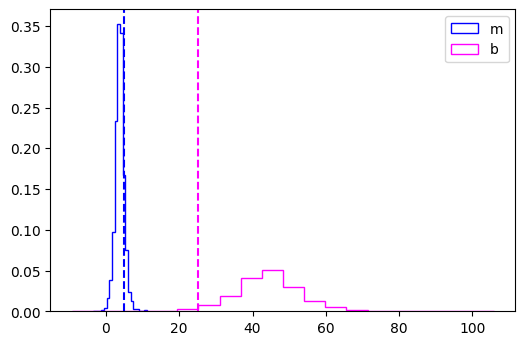

In [401]:
plt.hist(df['m'], histtype='step', bins=20, density=1, color='blue', label='m')
plt.axvline(x=m, linestyle='dashed', color='blue')
plt.hist(df['b'], histtype='step', bins=20, density=1, color='magenta', label='b')
plt.axvline(x=b, linestyle='dashed', color='magenta')
plt.legend()
plt.show()

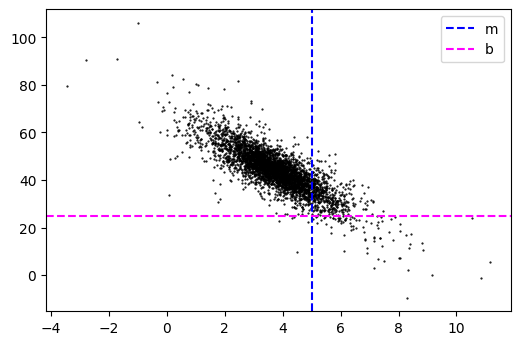

In [402]:
plt.scatter(df['m'],df['b'], s=0.3, color='black')
plt.axvline(m, linestyle='dashed', label='m', color='blue')
plt.axhline(b, linestyle='dashed', label='b', color='magenta')
plt.legend()
plt.show()

The small biased introduced because of the measurement close to the town, yields unsatisfactory results.  Let's improve the model

### Biased data on model with bias

In [390]:
model = stan.build(contamination_model_with_bias, data=contamination_data_biased, random_seed=1);

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 

In file included from /home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/sequi/.cache/httpstan/4.10.1/models/dx66igtd/model_dx66igtd.cpp:2:
/home/sequi/.local/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instan

Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s


/home/sequi/.cache/httpstan/4.10.1/models/dx66igtd/model_dx66igtd.cpp: In instantiation of ‘void model_dx66igtd_namespace::model_dx66igtd::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/sequi/.cache/httpstan/4.10.1/models/dx66igtd/model_dx66igtd.cpp:413:50:   required from here
/home/sequi/.cache/httpstan/4.10.1/models/dx66igtd/model_dx66igtd.cpp:286:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  286 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/sequi/.cache/httpstan/4.10.1/models/dx66igtd/model_dx66igtd.cpp: In instantiation of ‘void model_dx66igtd_namespace::model_dx66igtd::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector

Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 1

Building: 18.7s, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [391]:
fit = model.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_dfhjlmxp/model_dx66igtd.stan', line 21, column 3 to column 50)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severel

In [392]:
df = fit.to_frame() 

In [393]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,m,b,sigma,bias
draws,,,,,,,,,,,
0,-29.142961,0.989596,0.215127,3.0,15.0,0.0,31.876751,3.564791,50.872661,20.682922,12.215916
1,-26.166020,0.988432,0.198403,3.0,15.0,0.0,27.290850,4.595152,34.725209,13.300759,2.967889
2,-33.559824,0.984651,0.154522,2.0,3.0,0.0,33.744344,4.479827,16.504221,24.088299,1.588928
3,-29.682913,1.000000,0.282576,3.0,15.0,0.0,30.317206,2.893629,31.608615,22.550965,8.318644
4,-28.250754,0.916895,0.215127,4.0,15.0,0.0,30.848788,3.529484,42.352193,10.709011,0.340486
...,...,...,...,...,...,...,...,...,...,...,...
3995,-29.761404,0.998325,0.282576,3.0,7.0,0.0,34.987692,1.700621,46.189500,24.454997,4.907393
3996,-28.976229,0.994587,0.215127,4.0,15.0,0.0,30.832457,7.153527,14.054596,22.350699,23.232026
3997,-28.956073,1.000000,0.198403,4.0,15.0,0.0,33.689201,6.677141,13.124093,24.293517,17.316027


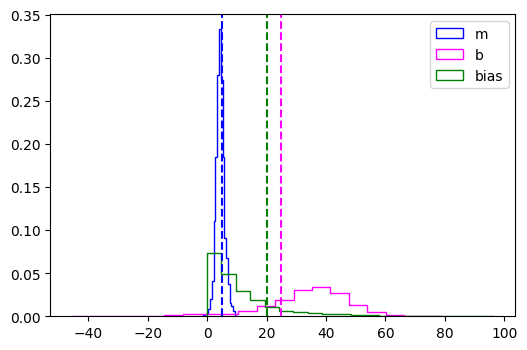

In [394]:
plt.hist(df['m'], histtype='step', bins=20, density=1, color='blue', label='m')
plt.axvline(x=m, linestyle='dashed', color='blue')
plt.hist(df['b'], histtype='step', bins=20, density=1, color='magenta', label='b')
plt.axvline(x=b, linestyle='dashed', color='magenta')
plt.hist(df['bias'], histtype='step', bins=20, density=1, color='green', label='bias')
plt.axvline(x=bias, linestyle='dashed', color='green')
plt.legend()
plt.show()

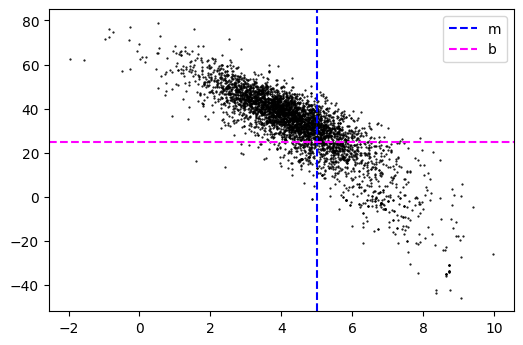

In [395]:
plt.scatter(df['m'],df['b'], s=0.3, color='black')
plt.axvline(m, linestyle='dashed', label='m', color='blue')
plt.axhline(b, linestyle='dashed', label='b', color='magenta')
plt.legend()
plt.show()

This captures much better the data!

- Observe that the model does not have an explicit 'likelihood' at this level.  We just tell the model a relationship between the data and the parameters
- Try at home: change the 1/10 in the exponential to a new parameter to be inferred (try using more datapoints)